In [1]:
%matplotlib inline 
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import glob
import random
import re
import time
import math
import os
import sys
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
import importlib
sys.path.append('..')
import Shared  # Shared.py holds functions common to all notebooks
importlib.reload(Shared)  # In case you make changes to the Shared.py file and don't want to restart the nb kernel 

<module 'Shared' from '/home/eduardo/Desktop/Link to dynamic-projections/Models/Shared.py'>

In [3]:
nb_name = 'fashion-C2AE_32c_32c_32c_1568f_2f_40ep'  # Couldn't figure out how to get this automatically

In [4]:
X, info_df, n_revisions, CATEGORIES = Shared.load_drawings('../../Datasets/fashion/')
# Flatten Nx28x28 -> Nx784x1
N = len(X)
# np.reshape(X, (len(X), 1, 784))
# X_flat = np.reshape(np.ravel(X), (N, -1))
len(X), len(info_df), n_revisions, CATEGORIES

(10000,
 10000,
 10,
 {0: 'ankleboot',
  1: 'bag',
  2: 'coat',
  3: 'dress',
  4: 'pullover',
  5: 'sandal',
  6: 'shirt',
  7: 'sneaker',
  8: 'trouser',
  9: 'tshirt'})

In [5]:
info_df.head()

,X_index,drawing_cat_id,drawing_cat_str,drawing_id,t
0,0,9,tshirt,687,3
1,1,0,ankleboot,596,0
2,2,2,coat,589,8
3,3,5,sandal,399,1
4,4,2,coat,12,3


In [6]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

from keras import backend as K

In [7]:
input_img = Input(shape=(28, 28, 1))
# input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# encoded = Conv2D(2, (2, 2), activation='relu', padding='same', strides=(1,4))(x)
x = Flatten()(x)
encoded = Dense(2)(x)
x = Dense(1568)(encoded)
x = Reshape((7,7,32))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

ae = Model(input_img, decoded)
encoder = Model(input_img, encoded)
ae.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
flat

In [8]:
ae.compile(loss='mse', optimizer='adam')

In [9]:
%time ae.fit(np.array(X).reshape([-1, 28, 28, 1]), np.array(X).reshape([-1, 28, 28, 1]), nb_epoch=40)

Instructions for updating:
Use tf.cast instead.


/home/eduardo/.local/share/virtualenvs/dynamic-projections-ak_z834q/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/40
10000/10000 [==============================] - 71s 7ms/step - loss: 0.0766
Epoch 2/40
10000/10000 [==============================] - 63s 6ms/step - loss: 0.0652
Epoch 3/40
10000/10000 [==============================] - 62s 6ms/step - loss: 0.0639
Epoch 4/40
10000/10000 [==============================] - 63s 6ms/step - loss: 0.0633
Epoch 5/40
10000/10000 [==============================] - 66s 7ms/step - loss: 0.0628
Epoch 6/40
10000/10000 [==============================] - 67s 7ms/step - loss: 0.0622
Epoch 7/40
10000/10000 [==============================] - 63s 6ms/step - loss: 0.0617
Epoch 8/40
10000/10000 [==============================] - 62s 6ms/step - loss: 0.0613
Epoch 9/40
10000/10000 [==============================] - 87s 9ms/step - loss: 0.0611
Epoch 10/40
10000/10000 [==============================] - 90s 9ms/step - loss: 0.0607
Epoch 11/40
10000/10000 [==============================] - 84s 8ms/step - loss: 0.0606
Epoch 12/40
10000/10000 [===========================

In [10]:
# ae.save('../Models/{}.h5'.format(nb_name))

In [11]:
# from keras.models import load_model
# ae = load_model('../Models/{}.h5'.format(nb_name))


Text(0.5, 0.98, 'loss')

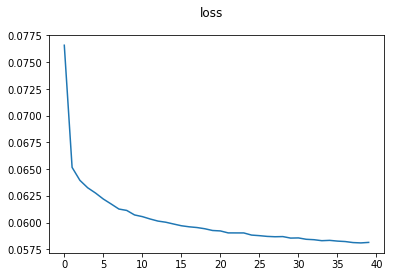

In [17]:
plt.figure()
plt.plot(ae.history.history['loss'])
plt.suptitle('loss')

In [13]:
#Shared.save_quickdraw_activations(ae, np.array(X).reshape([-1, 28, 28, 1]), info_df, n_revisions, nb_name)

In [14]:
# Collect all activations
middle = int(len(ae.layers)/2 - 1)
middle_layer_output = K.function([encoder.layers[0].input],
                                 [encoder.layers[-1].output])
layer_output = middle_layer_output([np.array(X).reshape([-1, 28, 28, 1])])[0]

In [15]:
layer_output.shape

(10000, 2)

In [16]:
# Write activations to csv
header = ['id']
for t in range(n_revisions):
    for d in range(layer_output.shape[1]):
        header.append('t{}d{}'.format(t, d))

csv_out = []
gb = info_df.groupby(['drawing_cat_str', 'drawing_id'])
for index, df in gb:  # Iterave over all drawing sequences
    drawing_id = index[0] + '-' + str(index[1])
    item_row = [drawing_id]
    for index, _ in df.sort_values('t').iterrows():  # For all timesteps
        for d in range(layer_output.shape[1]):  # Add all dimensions
            item_row.append(layer_output[index][d])
    csv_out.append(item_row)

df_out = pd.DataFrame(csv_out, columns=header)
df_out.to_csv('../../Output/{}.csv'.format(nb_name), index=False)